In [1]:
## !pip install -U tensorflow==2.7.1
## !pip install scikeras
!pip install pretty-confusion-matrix
!pip install transformers
!pip install pytorch-transformers
!pip install -U sentence-transformers

ERROR: Ignored the following versions that require a different python version: 0.1.0 Requires-Python >=3.7.1,<3.11; 0.1.1 Requires-Python >=3.7.1,<3.11
ERROR: Could not find a version that satisfies the requirement pretty-confusion-matrix (from versions: none)
ERROR: No matching distribution found for pretty-confusion-matrix

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np 
import pandas as pd 
import csv
import pickle
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from keras.layers import Bidirectional, Input, Dense, Layer, Dropout, LSTM, RepeatVector, Concatenate, Flatten
from keras.models import Sequential, Model
from tensorflow.python.keras.callbacks import EarlyStopping
from keras import backend as K

In [3]:
print(tf.__version__)

2.13.0


In [4]:
#  HYPERPARAMETERS
NUM_OF_ASPECTS = 7
EPOCHS = 150
MAXLEN = 768 # Since SciBERT returns 768 embeddings vector
LSTM_UNITS = 256

## ADD PATH OF THE PRE-TRAINED MODEL HERE ##
SAVE_PATH = "./Our-Proposed-Model.h5" 

### **1) DATASET** : 

I. **REVIEWS** <br>
II. **LABELS:**<br>

**A. Aspect Category**
1.  Clarity (CLA)
2. Motivation/Impact (MOT)
2.   Originality (ORI)
3.   Soundness/Correctness (SOU)
2.   Substance (SUB)
1.   Replicability (REP)
2.   Meaningful Comparison (CMP)
<br>

**B. Aspect Sentiment** <br>
1.  Positive
2.  Negative



### **2) LOAD DATASET**


**NOTE:** Update the URL PATH accordingly

In [5]:
import pickle

# LOAD REVIEWS LABELS & EMBEDS
with open('./reviews_train.pickle', 'rb') as handle:
    reviews_train = pickle.load(handle)
    handle.close()

with open('./reviews_test.pickle', 'rb') as handle:
    reviews_test = pickle.load(handle)
    handle.close()

with open('./y_ohe_train.pickle', 'rb') as handle:
    y_ohe_train = pickle.load(handle)
    handle.close()
    
with open('./y_ohe_test.pickle', 'rb') as handle:
    y_ohe_test = pickle.load(handle)
    handle.close()

# SCIBERT
with open('./sci_embeds_train.pickle', 'rb') as handle:
    sci_embeds_train = pickle.load(handle)
    handle.close()
    
with open('./sci_embeds_test.pickle', 'rb') as handle:
    sci_embeds_test = pickle.load(handle)
    handle.close()

,MOT,ORI,SOU,SUB,REP,CMP,CLA,polarity
0,0,0,0,0,0,1,0,-1
1,1,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,-1
3,0,0,0,0,0,0,1,1
4,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
161230,1,0,0,0,0,0,0,-1
161231,0,0,0,0,0,0,1,-1
161232,0,0,0,0,1,0,0,-1
161233,0,0,0,0,0,0,1,1


In [7]:
aspect_categories = y_ohe_train.columns[:-1]
y_ohe_train['polarity'] = np.where(y_ohe_train['polarity'] == -1, 0, 1)
y_ohe_test['polarity'] = np.where(y_ohe_test['polarity'] == -1, 0, 1)

In [8]:
train_embeds = sci_embeds_train
test_embeds = sci_embeds_test

In [9]:
train_embeds.shape , y_ohe_train.shape

(TensorShape([161235, 1, 768]), (161235, 8))

In [10]:
test_embeds.shape , y_ohe_test.shape

(TensorShape([40309, 1, 768]), (40309, 8))

### **3) SCIBERT**

In [11]:
from transformers import pipeline, AutoTokenizer, AutoModel

In [12]:
## SCIBERT
embed_model_name = 'gsarti/scibert-nli'

In [13]:
tokenizer = AutoTokenizer.from_pretrained(embed_model_name) 
embed_model = AutoModel.from_pretrained(embed_model_name)

In [14]:
def sent2embed(model, sent):
    inputs = tokenizer(sent, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    return outputs

# SAMPLE SCIBERT
sent = ['This work studies the predictive uncertainty issue of deep learning models.']
outputs = sent2embed(embed_model, sent)
outputs[1].shape


torch.Size([1, 768])

In [15]:
# PRE-PROCESS -- SCIBERT-EMBED
def sciBertEmbed(reviews, y_train, model):
    embed_arr = []
    #   y_train_arr=[]
    start = reviews.index[0]
    for idx in range(len(reviews.index)):
        print(start + idx)
        outputs = sent2embed(model, reviews.loc[start+idx])
        embed_arr.append([outputs[1].detach().numpy()[0]])
        # y_train_arr.append([y_train.loc[0].values])

    embed_train_arr = tf.stack(embed_arr)
    # y_train = tf.stack(y_train_arr)

    return embed_train_arr, y_train

### **4) Attention**

In [16]:
class Attention(Layer):
    
    def __init__(self, return_sequences=True, **kwargs):
        super(Attention,self).__init__()
        self.return_sequences = return_sequences
        super(Attention, self).__init__(**kwargs)

    def get_config(self):
        config = super(Attention, self).get_config().copy()
        config.update({
            'return_sequences': self.return_sequences , 
        })
        return config


    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        e =K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        a =K.softmax(e)
        a=K.expand_dims(a,axis=-1)
        output = x*a
        
        return K.sum(output, axis=1) 

In [17]:
train_embeds2 = train_embeds
test_embeds2 = test_embeds 

### **5) DEFINE OUR MODEL**

In [19]:
embed = Input(shape=  (None,MAXLEN), name='INPUT')
biLSTM = Bidirectional(LSTM(LSTM_UNITS , return_sequences=False) , name='BILSTM' )(embed)
repeat_op = RepeatVector(1)(biLSTM)

attentions=[]
for i in range(NUM_OF_ASPECTS):
  x = Attention(return_sequences=False)(repeat_op)
  attentions.append(x)

concate_attention  = Concatenate()(attentions)
flatten = Flatten()(concate_attention)

# BRANCH 1
b1_x =  Dense(1000, activation='relu', name='CATEGORY_DENSE')(flatten)
category_output = Dense(NUM_OF_ASPECTS, activation='softmax', name='CATEGORY_OUTPUT')(b1_x)

# BRANCH 2
dense2 =  Dense(60, activation='relu', name='POLARITY_DENSE')(flatten)
polarity_output = Dense(1, activation='sigmoid', name='POLARITY_OUTPUT')(dense2)

multitask_model = Model(inputs=embed, outputs=[category_output, polarity_output])

In [20]:
metrics =[ 
    'accuracy', 
    tf.keras.metrics.Precision(), 
    tf.keras.metrics.Recall()
]

# cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)

loss = { 'CATEGORY_OUTPUT': 'categorical_crossentropy', 
        'POLARITY_OUTPUT': 'binary_crossentropy'
       }

lossWeights = { 'CATEGORY_OUTPUT': 1.0, 
               'POLARITY_OUTPUT': 1.0
              }


multitask_model.compile(loss= loss,
                        loss_weights = lossWeights,
                        optimizer='adam', 
                        metrics=['accuracy']) 


multitask_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, None, 768)]          0         []                            
                                                                                                  
 BILSTM (Bidirectional)      (None, 512)                  2099200   ['INPUT[0][0]']               
                                                                                                  
 repeat_vector (RepeatVecto  (None, 1, 512)               0         ['BILSTM[0][0]']              
 r)                                                                                               
                                                                                                  
 attention_1 (Attention)     (None, 512)                  513       ['repeat_vector[0][0]']   

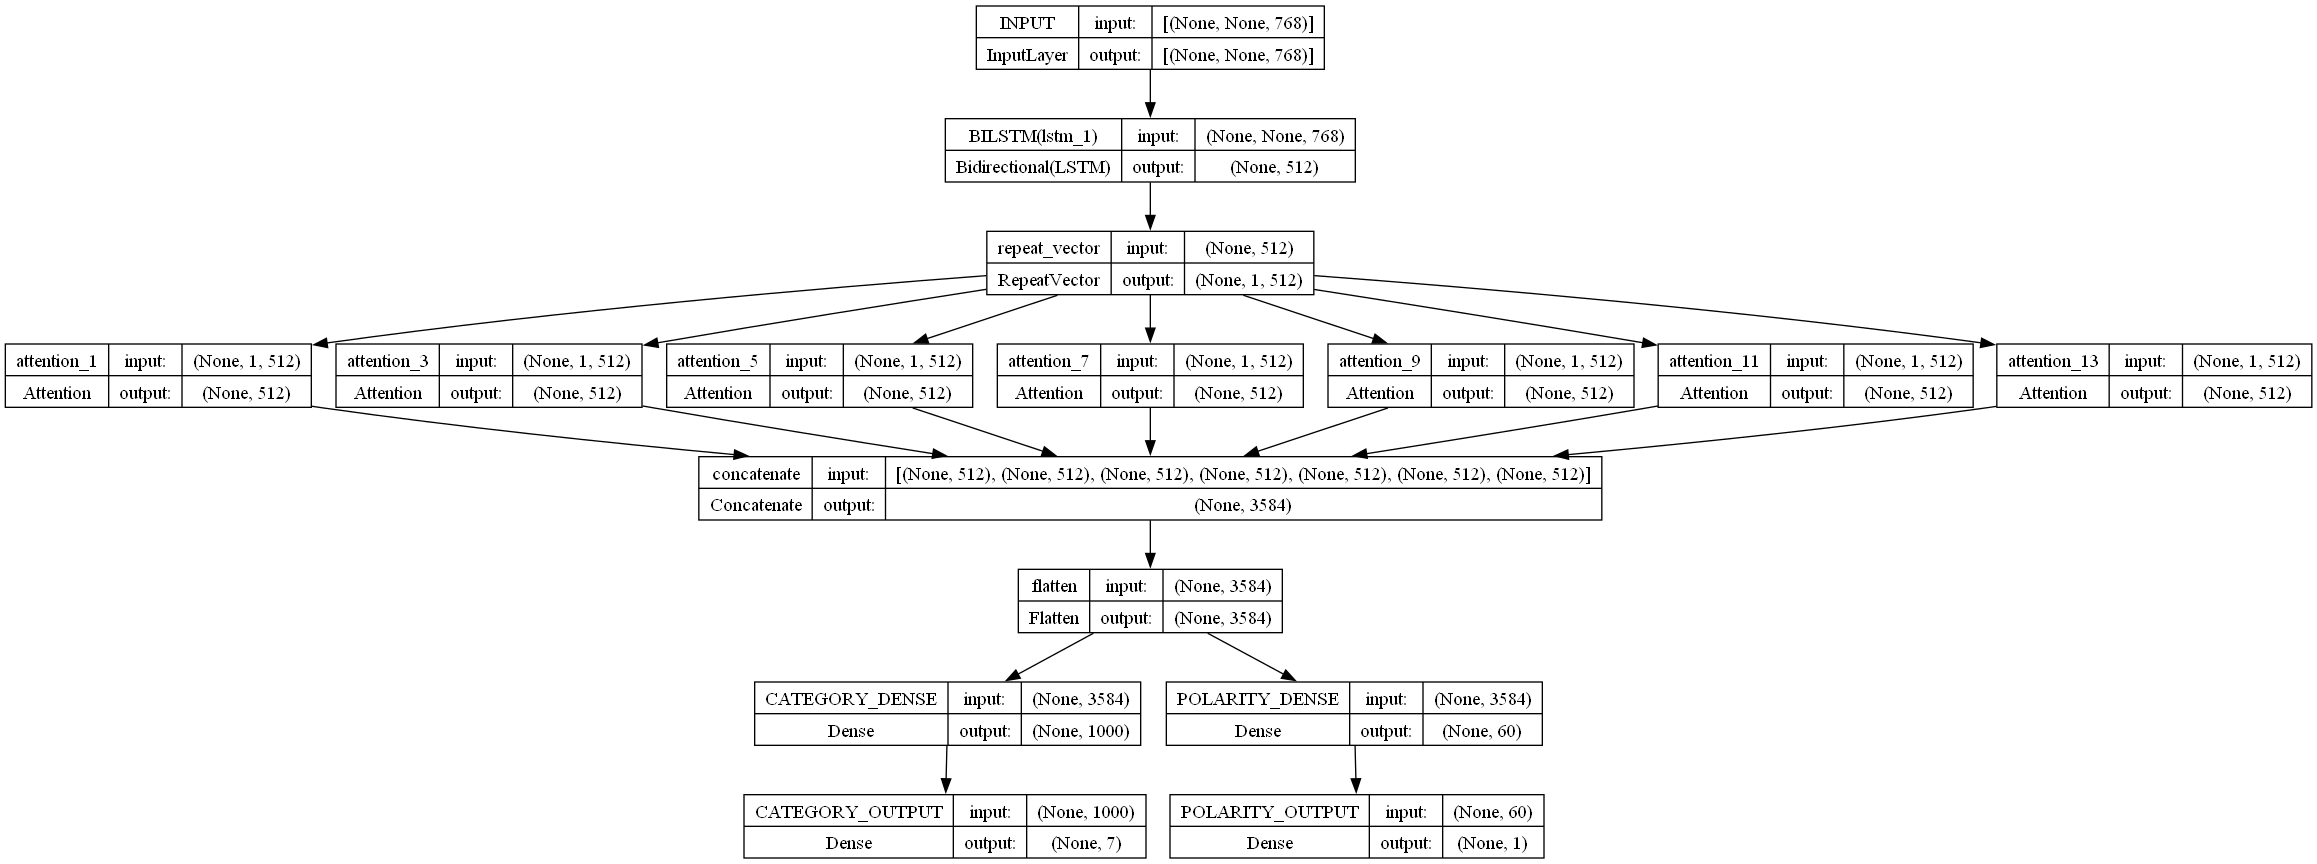

In [21]:
tf.keras.utils.plot_model(multitask_model, to_file='multi-task_model.png', show_shapes=True)

In [26]:
import torch
print("CUDA Available: ", torch.cuda.is_available())

CUDA Available:  False


### **6) FIT MODEL**

In [22]:
history = multitask_model.fit(
                          train_embeds2, 
                          y =  {
                          'CATEGORY_OUTPUT': y_ohe_train[aspect_categories].values, 
                          'POLARITY_OUTPUT': y_ohe_train.polarity.values
                          },  
                           validation_data = (test_embeds2, {
                          'CATEGORY_OUTPUT': y_ohe_test[aspect_categories].values, 
                          'POLARITY_OUTPUT': y_ohe_test.polarity.values
                           }),
                           epochs = 25,
                           shuffle=True,
                           verbose=2
                          )

Epoch 1/25


KeyboardInterrupt: 

In [35]:
multitask_model.save('./model_wo_attention.h5', overwrite=True, save_format="tf")
print("Weights Saved")

Weights Saved


In [37]:
# LOAD MODEL
from keras.models import load_model
LOAD_PATH = SAVE_PATH
# LOAD_PATH = "../input/berth5/MultiTask-Ablation_WithoutAttention-epoch150.h5"
model = load_model('./model_wo_attention.h5', custom_objects={'Attention': Attention})

print("MODEL LOADED\n\n")

model.evaluate(test_embeds2, [y_ohe_test[aspect_categories].values, y_ohe_test.polarity.values] )

MODEL LOADED


1260/1260 [==============================] - 13s 9ms/step - loss: 0.6635 - CATEGORY_OUTPUT_loss: 0.5469 - POLARITY_OUTPUT_loss: 0.1166 - CATEGORY_OUTPUT_accuracy: 0.8100 - POLARITY_OUTPUT_accuracy: 0.9543


[0.6635124087333679,
 0.5469063520431519,
 0.11660617589950562,
 0.8100175857543945,
 0.9543278217315674]

### **7) ANALYSIS**

In [38]:
history.history.keys()

dict_keys(['loss', 'CATEGORY_OUTPUT_loss', 'POLARITY_OUTPUT_loss', 'CATEGORY_OUTPUT_accuracy', 'POLARITY_OUTPUT_accuracy', 'val_loss', 'val_CATEGORY_OUTPUT_loss', 'val_POLARITY_OUTPUT_loss', 'val_CATEGORY_OUTPUT_accuracy', 'val_POLARITY_OUTPUT_accuracy'])

In [39]:
metrics_keys = list(history.history.keys())

loss = history.history[metrics_keys[0]]
category_loss = history.history[metrics_keys[1]]
polarity_loss = history.history[metrics_keys[2]]
category_acc = history.history[metrics_keys[3]]
polarity_acc = history.history[metrics_keys[4]]
val_loss = history.history[metrics_keys[5]]
val_category_loss = history.history[metrics_keys[6]]
val_polarity_loss = history.history[metrics_keys[7]]
val_category_acc = history.history[metrics_keys[8]]
val_polarity_acc = history.history[metrics_keys[9]]


print("\nCATEGORY ACCURACY : " , category_acc)
print("\nPOLARITY ACCURACY : " , polarity_acc)
print("\nVAL CATEGORY ACCURACY : " ,val_category_acc)
print("\nVAL POLARITY ACCURACY : " ,val_polarity_acc)

print("\nLOSS : " , loss)
print("\nVAL LOSS : " , val_loss)
print("\nCATEGORY LOSS : " , category_loss)
print("\nCATEGORY VAL LOSS : " , val_category_loss)
print("\nPOLARITY LOSS : " , polarity_loss)
print("\nVAL POLARITY LOSS : " , val_polarity_loss)


CATEGORY ACCURACY :  [0.6692033410072327, 0.7194901704788208, 0.7389214634895325, 0.7540794610977173, 0.767519474029541, 0.7796756029129028, 0.7937730550765991, 0.8055012822151184, 0.8183086514472961, 0.8274133801460266]

POLARITY ACCURACY :  [0.9272924661636353, 0.9391385316848755, 0.9437218904495239, 0.9476044178009033, 0.9495146870613098, 0.9530684947967529, 0.9559276700019836, 0.9594504833221436, 0.9607653617858887, 0.9631717801094055]

VAL CATEGORY ACCURACY :  [0.7055744528770447, 0.7283981442451477, 0.746111273765564, 0.7507504820823669, 0.766379714012146, 0.7694559693336487, 0.7817857265472412, 0.7928502559661865, 0.7964226603507996, 0.8100175857543945]

VAL POLARITY ACCURACY :  [0.9359696507453918, 0.9419484734535217, 0.9452479481697083, 0.9411545991897583, 0.9463395476341248, 0.9505569338798523, 0.9546751379966736, 0.9516733288764954, 0.9554938077926636, 0.9543278217315674]

LOSS :  [1.0867879390716553, 0.9264391660690308, 0.8572487235069275, 0.8100227117538452, 0.76435941457

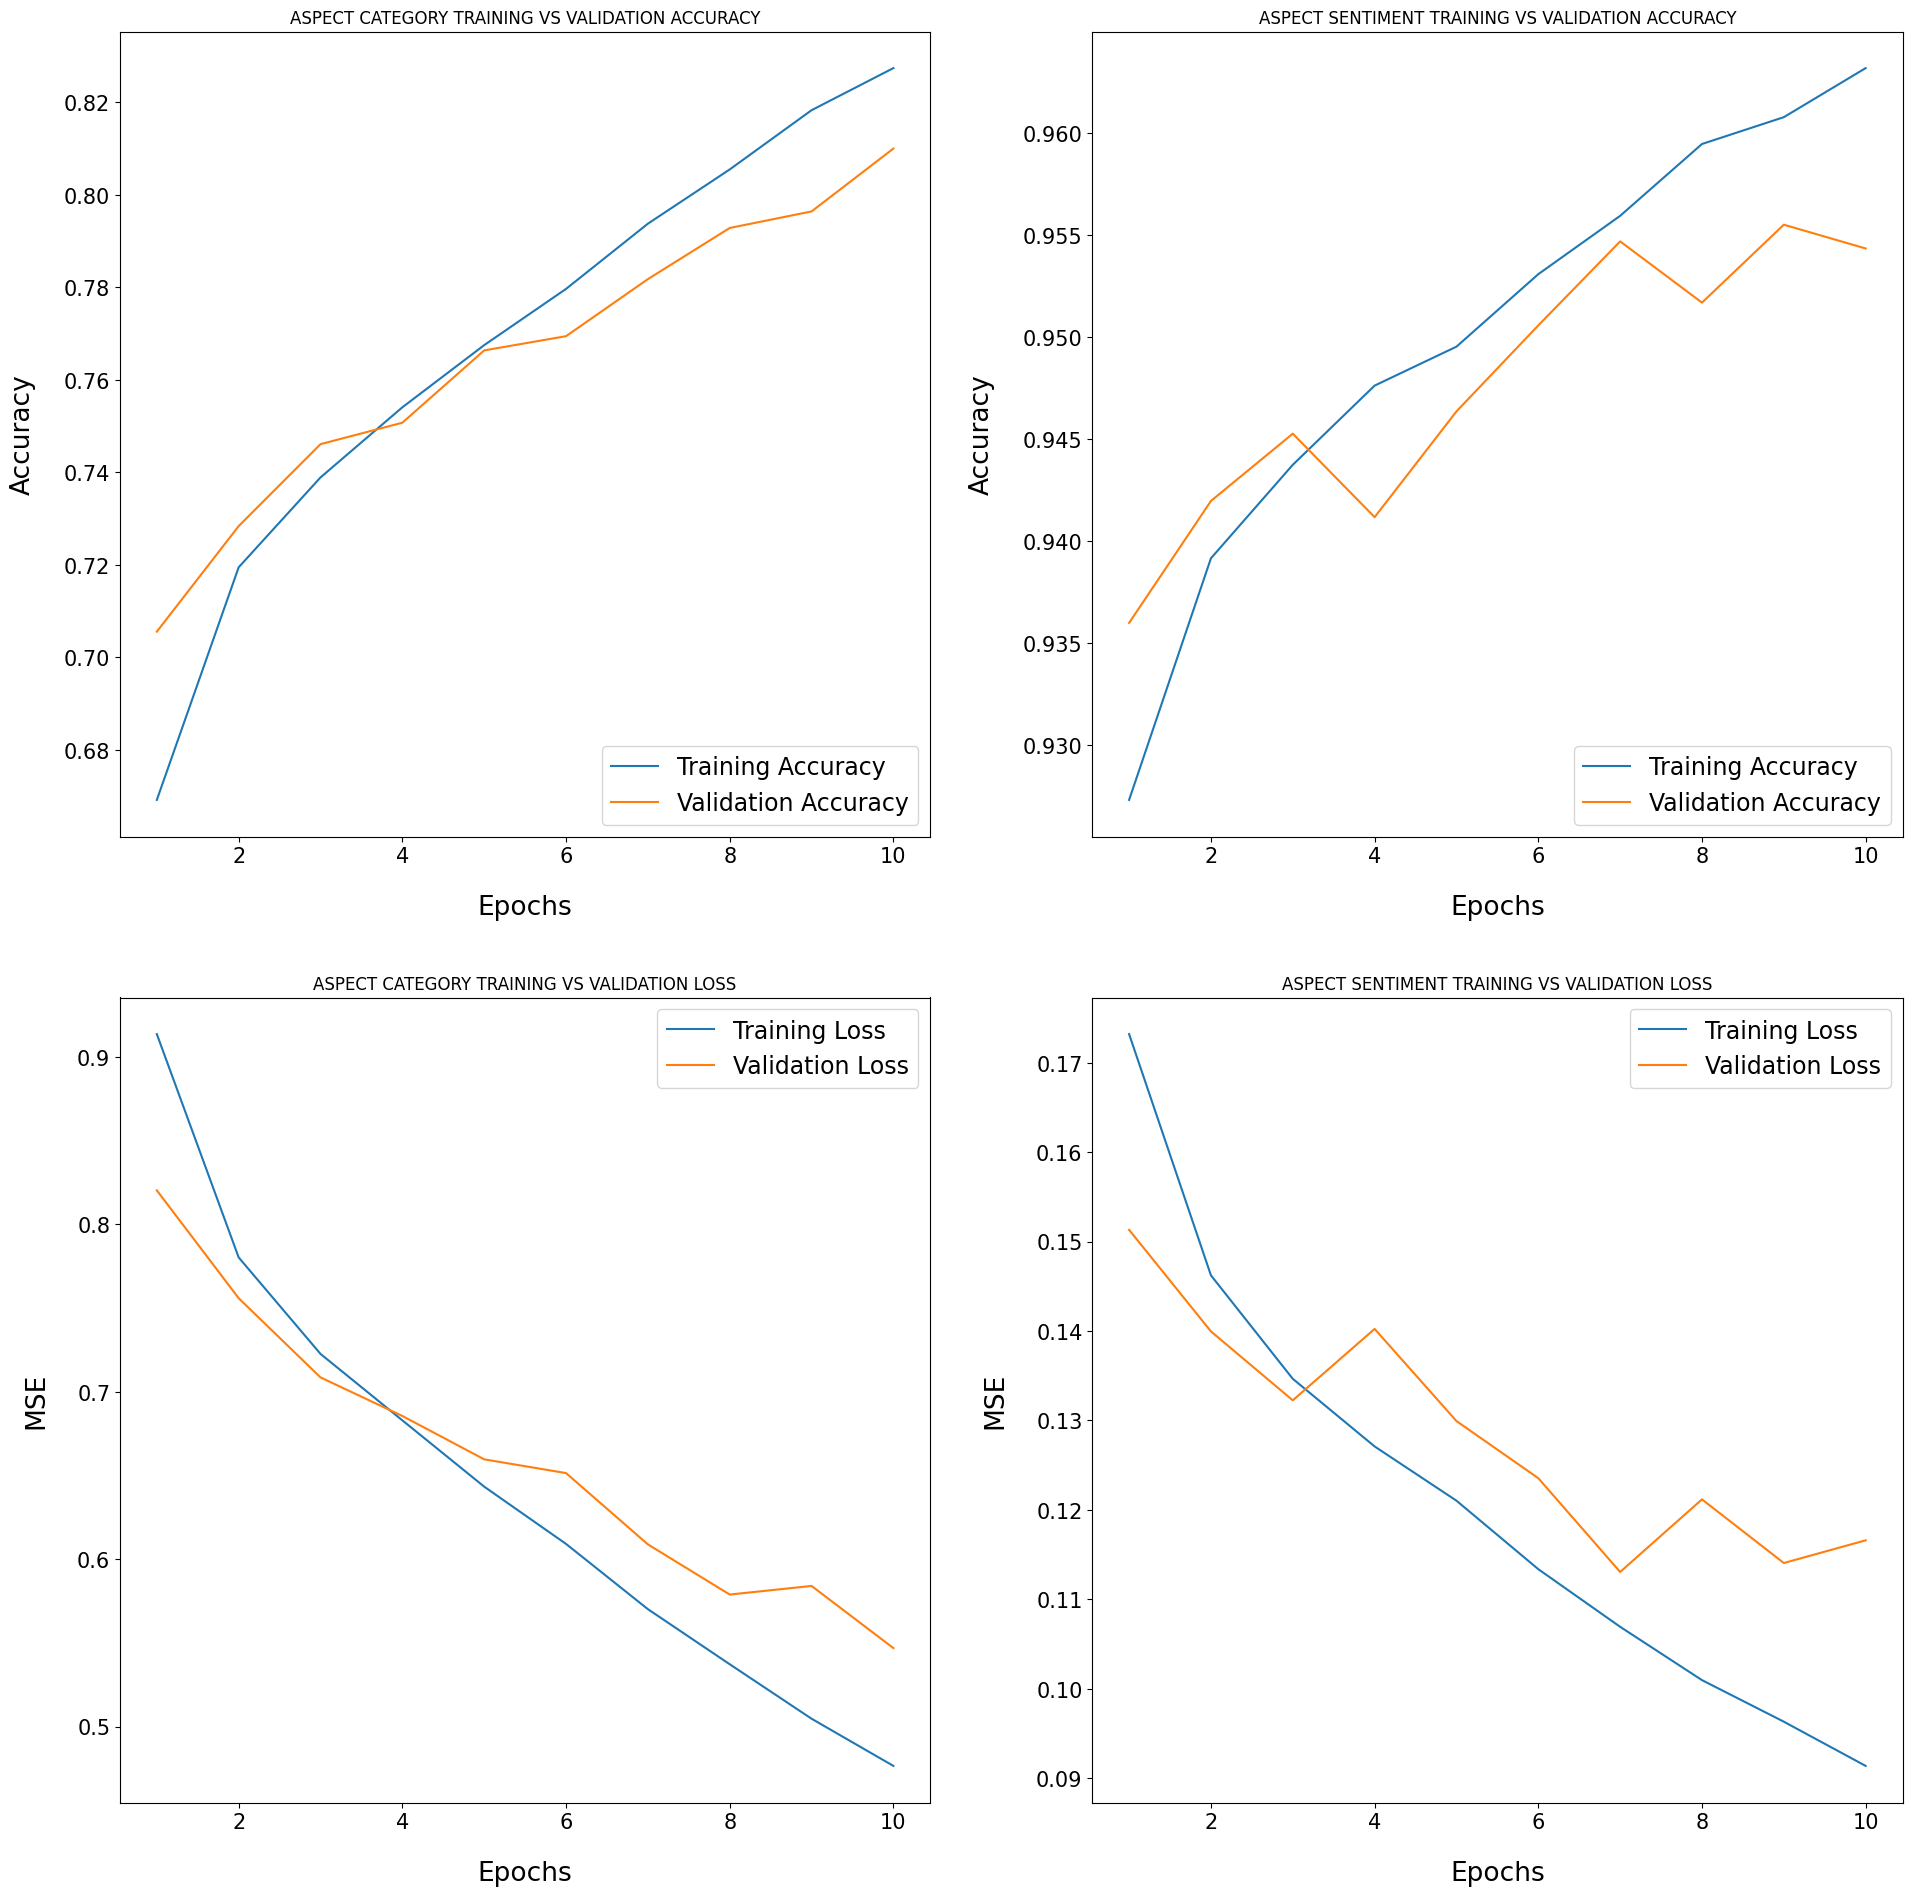

In [40]:
metrics = history.history['loss']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 23))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, category_acc, label='Training Accuracy')
plt.plot(epochs_range, val_category_acc, label='Validation Accuracy')
plt.title('ASPECT CATEGORY TRAINING VS VALIDATION ACCURACY')
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('Accuracy', fontsize=19, labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=15, )
plt.legend(fontsize=17, loc='lower right')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, polarity_acc, label='Training Accuracy')
plt.plot(epochs_range, val_polarity_acc, label='Validation Accuracy')
plt.title('ASPECT SENTIMENT TRAINING VS VALIDATION ACCURACY')
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('Accuracy', fontsize=19, labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=17, loc='lower right')

plt.subplot(2, 2, 3)
plt.plot(epochs_range,category_loss, label='Training Loss')
plt.plot(epochs_range, val_category_loss, label='Validation Loss')
plt.title('ASPECT CATEGORY TRAINING VS VALIDATION LOSS')
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('MSE', fontsize=19, labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=17)

plt.subplot(2, 2, 4)
plt.plot(epochs_range,polarity_loss, label='Training Loss')
plt.plot(epochs_range, val_polarity_loss, label='Validation Loss')
plt.title('ASPECT SENTIMENT TRAINING VS VALIDATION LOSS')
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('MSE', fontsize=19, labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=17)
           
           
plt.show()




### **8)VALIDATION**

In [41]:
categories = y_ohe_train.columns[:-1]
polarity_labels = ['POSITIVE', 'NEGATIVE']

In [42]:
# ASPECT CATEGORY
y_pred_aspect = multitask_model.predict(test_embeds2)
y_pred_categories = y_pred_aspect[0]
y_pred_polarity = y_pred_aspect[1].reshape(-1)
y_pred_polarity =  [ round(ele) for ele in y_pred_polarity ]

y_pred_aspect_idx = np.argmax(y_pred_categories, axis=1)
y_test_idx =np.argmax(y_ohe_test[aspect_categories].values, axis=1)


1260/1260 [==============================] - 11s 8ms/step


In [43]:
# CONFUSION MATRIX
import seaborn as sns
from sklearn.metrics import confusion_matrix as cm

cm_aspect = cm(y_test_idx, y_pred_aspect_idx)
cm_polarity = cm(y_ohe_test.polarity.values, y_pred_polarity)

In [44]:
# CLASS-WISE ACCURACY
cm_aspect_acc = cm_aspect.astype('float') / cm_aspect.sum(axis=1)[:, np.newaxis]
aspect_acc =cm_aspect_acc.diagonal()

# POLARITY ACCURACY
cm_polarity_acc = cm_polarity.astype('float') / cm_polarity.sum(axis=1)[:, np.newaxis]
polarity_acc =cm_polarity_acc.diagonal()

# ASPECT CATEGORY
print('*** CLASS-WISE ACCURACY : **** \n')
print("CLASS\tACCURACY")
for cat, acc in zip(aspect_categories, aspect_acc):
    print('',cat,"\t",round(acc, 3))
    
# POLARITY
print('\n\n*** POLARITY ACCURACY : **** \n')
print("CLASS\t\tACCURACY")
for cat, acc in zip(polarity_labels, polarity_acc):
    print(cat,"\t",round(acc, 3))

*** CLASS-WISE ACCURACY : **** 

CLASS	ACCURACY
 MOT 	 0.82
 ORI 	 0.857
 SOU 	 0.671
 SUB 	 0.716
 REP 	 0.944
 CMP 	 0.838
 CLA 	 0.825


*** POLARITY ACCURACY : **** 

CLASS		ACCURACY
POSITIVE 	 0.945
NEGATIVE 	 0.969


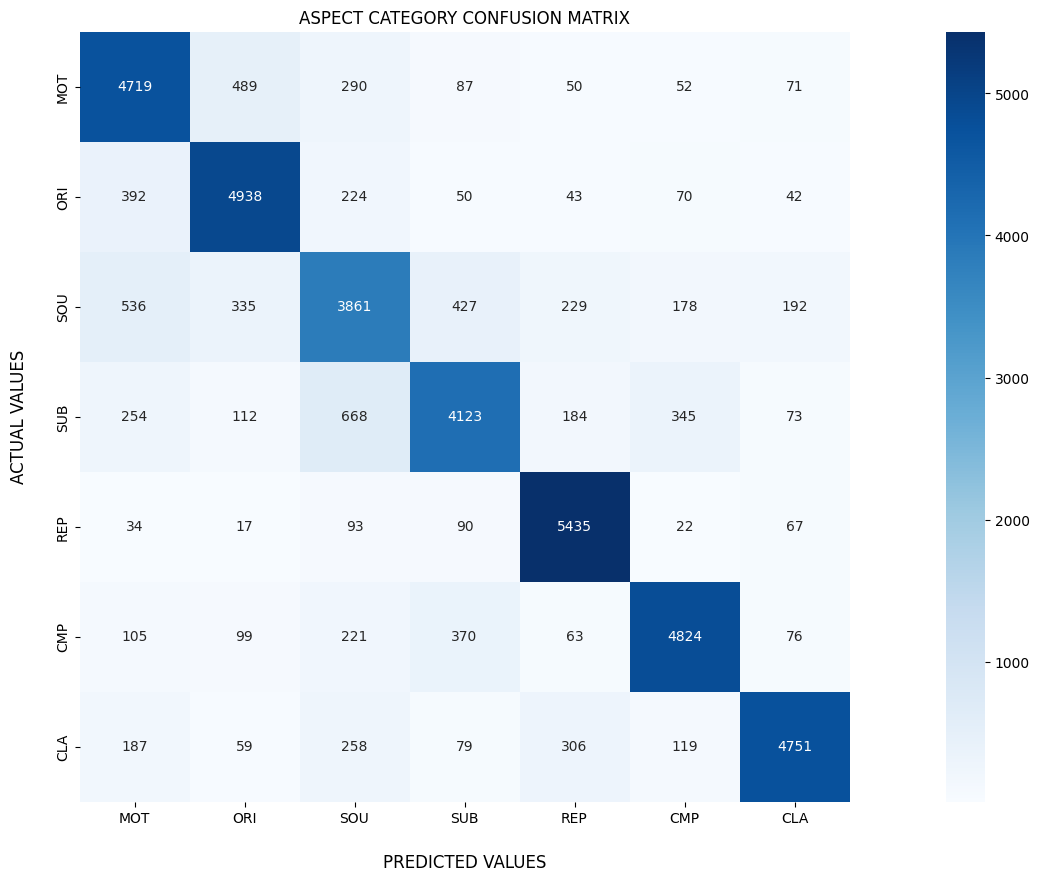

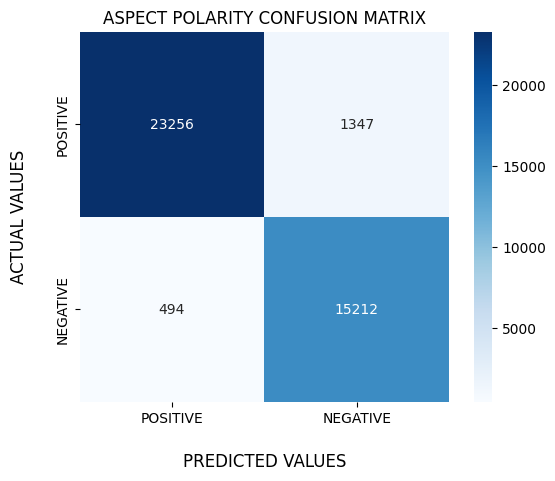

In [45]:
plt.figure(figsize=(25, 10))
sns.heatmap(cm_aspect, square=True, annot=True, cmap='Blues', fmt='d', cbar=True, yticklabels=categories, xticklabels=categories)

plt.xlabel('PREDICTED VALUES', fontsize=12, labelpad=20)
plt.ylabel('ACTUAL VALUES', fontsize=12, labelpad=20)
plt.title('ASPECT CATEGORY CONFUSION MATRIX')
plt.show()

sns.heatmap(cm_polarity, square=True, annot=True, cmap='Blues', fmt='d', cbar=True, yticklabels=polarity_labels, xticklabels=polarity_labels)
plt.xlabel('PREDICTED VALUES', fontsize=12, labelpad=20)
plt.ylabel('ACTUAL VALUES', fontsize=12, labelpad=20)
plt.title('ASPECT POLARITY CONFUSION MATRIX')
plt.show()

In [ ]:
from pretty_confusion_matrix import pp_matrix

df_cm = pd.DataFrame(cm_aspect, index=categories, columns=categories)
cmap = 'PuRd'
pp_matrix(df_cm, cmap=cmap)

In [ ]:
df_polarity = pd.DataFrame(cm_polarity, index=polarity_labels, columns=polarity_labels)
cmap = 'PuRd'
pp_matrix(df_polarity, cmap=cmap)

In [48]:
# CLASSIFICATION REPORT
from sklearn.metrics import classification_report
print(classification_report(y_test_idx, y_pred_aspect_idx, target_names=categories))
print('\n\n',classification_report(y_ohe_test.polarity.values, y_pred_polarity, target_names=polarity_labels))

              precision    recall  f1-score   support

         MOT       0.76      0.82      0.79      5758
         ORI       0.82      0.86      0.84      5759
         SOU       0.69      0.67      0.68      5758
         SUB       0.79      0.72      0.75      5759
         REP       0.86      0.94      0.90      5758
         CMP       0.86      0.84      0.85      5758
         CLA       0.90      0.82      0.86      5759

    accuracy                           0.81     40309
   macro avg       0.81      0.81      0.81     40309
weighted avg       0.81      0.81      0.81     40309



               precision    recall  f1-score   support

    POSITIVE       0.98      0.95      0.96     24603
    NEGATIVE       0.92      0.97      0.94     15706

    accuracy                           0.95     40309
   macro avg       0.95      0.96      0.95     40309
weighted avg       0.96      0.95      0.95     40309



## **INFERENCE MODEL**

In [49]:
def predictPreprocess(model, sent):
  outputs = sent2embed(model, sent)
  pred_X = np.array([outputs[1].detach().numpy()[0]])
  embed_X = tf.stack(pred_X)
  return embed_X

In [50]:
def inferenceModel(multi_model, embed_model, sent):
    labels = y_ohe_train.columns[:-1]
    sents= sent.split('.')[:-1]
    results =[]
    for s in sents:
        test_embed = predictPreprocess(embed_model, s.strip())
        category_probab = multi_model.predict(test_embed)
        category_label_idx = np.argmax(category_probab[0])
        category_polarity = 1 if category_probab[1][0][0] > 0.5 else 0
        category_label = 'POS' if category_probab[1][0][0] > 0.5 else 'NEG'
        results.append([labels[category_label_idx] , category_polarity, category_label])
        
    return results


In [51]:
# SAMPLE 1
sent = '''This paper presents a model-free policy gradient approach for reinforcement learning that combines on-policy 
updates with an off-policy critic . The hope is to learn continuous control in a sample-efficient fashion . The approach 
is validated on a number of low-dimensional continuous control tasks in a simulated environment .'''
op = inferenceModel(model,embed_model, sent)

print('PREDICTED OUTPUT :', op)

ValueError: in user code:

    File "c:\Users\prate\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\prate\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\prate\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\prate\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "c:\Users\prate\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\prate\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_1' (type Functional).
    
    Input 0 of layer "BILSTM" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 768)
    
    Call arguments received by layer 'model_1' (type Functional):
      • inputs=tf.Tensor(shape=(None, 768), dtype=float32)
      • training=False
      • mask=None


In [ ]:
# SAMPLE 2
sent = '''However , since the processing of sequential data seems to be a broad and general area of application , it is 
conceivable that this work will be useful in the design and application of future CNNs . All in all , this paper introduces 
an interesting idea to address an important topic .'''
op = inferenceModel(model,embed_model, sent)

print('PREDICTED OUTPUT :', op)